<font color="#CA3532"><h1 align="left">TFM: Evaluación de daños por terremotos.</h1></font>
<font color="#CA3532"><h3 align="left">PASO 1: Cruce de tablas y tratamiento de missings</h3></font>
<font color="#6E6E6E"><h3 align="right">Pilar Campos López</h3></font> 
<font color="#6E6E6E"><h3 align="right">Silvia Saenz</h3></font> 
<font color="#6E6E6E"><h3 align="right">Ana de Antonio</h3></font> 

A lo largo de este notebook se realizan los siguientes pasos:
- Cruzar las tablas
- Eliminar missing y rellenar los missing (de no hogares)
- Identificar los 71 registros erroneos y eliminarlos
- Optimización de las variables (int16 a int8 etc...)

## Importación de librerías y funciones necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

In [2]:
# pd.set_option ("display.max_rows", None)
# pd.set_option ("display.max_columns", None)
# pd.set_option ("display.max_colwidth",200)

In [3]:
def missing_values_table(df): 
    mis_val = df.isnull().sum() 
    mis_val_percent = 100 * df.isnull().sum() / len(df) 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) 
    mis_val_table_ren_columns = mis_val_table.rename( columns = {0 : 'Missing Values', 1 : '% of Total Values'}) 
    mis_val_table_ren_columns = mis_val_table_ren_columns[ mis_val_table_ren_columns.iloc[:,1] != 0].sort_values( '% of Total Values', ascending=False).round(1) 
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.") 
    return mis_val_table_ren_columns

## Importación de datos y cruce de tablas

### CSV BUILDING

Dejamos fuera el csv de Damage Assesment, así que construimos uno con los dos csvs de edificios ("structure y ownership")

In [4]:
df1=pd.read_csv("./Data/csv_building_structure.csv", sep=',')

In [5]:
df1.shape

(762106, 31)

In [6]:
df1.dtypes

building_id                                int64
district_id                                int64
vdcmun_id                                  int64
ward_id                                    int64
count_floors_pre_eq                        int64
count_floors_post_eq                       int64
age_building                               int64
plinth_area_sq_ft                          int64
height_ft_pre_eq                           int64
height_ft_post_eq                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_c

In [7]:
df2=pd.read_csv("./Data/csv_building_ownership_and_use.csv", sep=',')

In [8]:
df2.shape

(762106, 17)

In [9]:
df2.dtypes

building_id                        int64
district_id                        int64
vdcmun_id                          int64
ward_id                            int64
legal_ownership_status            object
count_families                   float64
has_secondary_use                float64
has_secondary_use_agriculture      int64
has_secondary_use_hotel            int64
has_secondary_use_rental           int64
has_secondary_use_institution      int64
has_secondary_use_school           int64
has_secondary_use_industry         int64
has_secondary_use_health_post      int64
has_secondary_use_gov_office       int64
has_secondary_use_use_police       int64
has_secondary_use_other            int64
dtype: object

Unimos las dos tabla cruzandolas por "building id"

In [10]:
building = pd.merge(df1,  df2,  how ='outer')  

In [11]:
building.shape

(762106, 44)

Eliminamos las predictoras, son las que contienen post y technical solution en su nombre

In [12]:
predictoras = [i for i,x in enumerate(building.columns) if ('post' in x) or ('solution' in x)]
building =building.drop(building.columns[predictoras],axis=1)

In [13]:
building.shape

(762106, 39)

In [14]:
building.head(5)

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,...,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,120101000011,12,1207,120703,1,9,288,9,Flat,Other,...,0.0,0,0,0,0,0,0,0,0,0
1,120101000021,12,1207,120703,1,15,364,9,Flat,Other,...,0.0,0,0,0,0,0,0,0,0,0
2,120101000031,12,1207,120703,1,20,384,9,Flat,Other,...,0.0,0,0,0,0,0,0,0,0,0
3,120101000041,12,1207,120703,1,20,312,9,Flat,Other,...,0.0,0,0,0,0,0,0,0,0,0
4,120101000051,12,1207,120703,1,30,308,9,Flat,Other,...,0.0,0,0,0,0,0,0,0,0,0


In [15]:
missing_values_table(building)

Your selected dataframe has 39 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
damage_grade,12,0.0
has_secondary_use,10,0.0
count_families,2,0.0
position,1,0.0
plan_configuration,1,0.0


Se van a eliminar las filas con missing aunque cuando crucemos esta tabla con households, los registros volveran a aparecer porque el building_id va a estar en household.
Lo quitamos ahora, para que los missing que queden luego sean los exclusivos de los no hogares.

In [16]:
var = ['damage_grade', 'has_secondary_use', 'count_families', 'position','plan_configuration']

In [17]:
def drop_nulls_rows(df, var):
    for i in var:
        df= df.drop(df.loc[df[i].isnull()].index)
    return df

In [18]:
building = drop_nulls_rows(building, var)

In [19]:
building.shape

(762093, 39)

In [20]:
#building= building.drop(building.loc[building['damage_grade'].isnull()].index)
#building= building.drop(building.loc[building['has_secondary_use'].isnull()].index)
#building= building.drop(building.loc[building['count_families'].isnull()].index)
#building= building.drop(building.loc[building['position'].isnull()].index)
#building= building.drop(building.loc[building['plan_configuration'].isnull()].index)

In [21]:
missing_values_table(building)

Your selected dataframe has 39 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Al eliminar los missing, quitamos 13 registros

### Identificamos las familias por edificio en OWNERSHIP

Vamos a hacer un group by de la variable "count_families" que viene en el csv de ownership:

In [22]:
familias_edificio= building.groupby("count_families").count()
familias_edificio

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,...,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count_families,,,,,,,,,,,,,,,,,,,,,
0.0,71576,71576,71576,71576,71576,71576,71576,71576,71576,71576,...,71576,71576,71576,71576,71576,71576,71576,71576,71576,71576
1.0,643409,643409,643409,643409,643409,643409,643409,643409,643409,643409,...,643409,643409,643409,643409,643409,643409,643409,643409,643409,643409
2.0,39751,39751,39751,39751,39751,39751,39751,39751,39751,39751,...,39751,39751,39751,39751,39751,39751,39751,39751,39751,39751
3.0,5685,5685,5685,5685,5685,5685,5685,5685,5685,5685,...,5685,5685,5685,5685,5685,5685,5685,5685,5685,5685
4.0,1215,1215,1215,1215,1215,1215,1215,1215,1215,1215,...,1215,1215,1215,1215,1215,1215,1215,1215,1215,1215
5.0,302,302,302,302,302,302,302,302,302,302,...,302,302,302,302,302,302,302,302,302,302
6.0,104,104,104,104,104,104,104,104,104,104,...,104,104,104,104,104,104,104,104,104,104
7.0,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
8.0,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15


In [23]:
building[building["count_families"]>1].count()

building_id                               47108
district_id                               47108
vdcmun_id                                 47108
ward_id                                   47108
count_floors_pre_eq                       47108
age_building                              47108
plinth_area_sq_ft                         47108
height_ft_pre_eq                          47108
land_surface_condition                    47108
foundation_type                           47108
roof_type                                 47108
ground_floor_type                         47108
other_floor_type                          47108
position                                  47108
plan_configuration                        47108
has_superstructure_adobe_mud              47108
has_superstructure_mud_mortar_stone       47108
has_superstructure_stone_flag             47108
has_superstructure_cement_mortar_stone    47108
has_superstructure_mud_mortar_brick       47108
has_superstructure_cement_mortar_brick  

In [24]:
# Total registros en building (quitando missing y predictoras) = 762.093  
                            
# Edificios con SOLO 1 familia = 643.409     
# Edificios con VARIAS FAMILIAS = 47.108    
# Edificios no hogares =71.576 (escuelas, iglesias, bancos....)              

### CSV HOUSEHOLDS

Se va a utilizar las variables del csv de households demographics

In [25]:
household=pd.read_csv("./Data/csv_household_demographics.csv", sep=',')

In [26]:
household.shape

(747365, 11)

In [27]:
household.dtypes

household_id                              int64
district_id                               int64
vdcmun_id                                 int64
ward_id                                   int64
gender_household_head                    object
age_household_head                      float64
caste_household                          object
education_level_household_head           object
income_level_household                   object
size_household                          float64
is_bank_account_present_in_household    float64
dtype: object

In [28]:
missing_values_table(household)

Your selected dataframe has 11 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
caste_household,228,0.0
education_level_household_head,228,0.0
income_level_household,228,0.0
is_bank_account_present_in_household,228,0.0
gender_household_head,2,0.0
age_household_head,2,0.0
size_household,2,0.0


In [29]:
var = ['caste_household', 'education_level_household_head', 'income_level_household', 'is_bank_account_present_in_household','gender_household_head', 'age_household_head', 'size_household'] 

In [30]:
def drop_nulls_rows(df, var):
    for i in var:
        df= df.drop(df.loc[df[i].isnull()].index)
    return df

In [31]:
household = drop_nulls_rows(household, var)

In [32]:
household.shape

(747137, 11)

In [33]:
missing_values_table(household)

Your selected dataframe has 11 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Al eliminar los missing, se han quitado 228 registros

Building id: es un código de 12 dígitos (ejemplo: 120101000011)
Household_id : es un código de 14 digitos, donde los dos últimos indica las familas en el mismo edificio. Ejemplo:
    12010100001101 -> el 01 del final indica 1 familia
    12010100001102 -> el 02 del final indica 2 familias en ese mismo edificio etc..

Para cruzar el csv de household con el csv de building, hay que crear una columna nueva en el csv de household extrayendo
los dos últimos dígitos para que se pueda cruzar. A esta columna nueva la llamaremos "building_id"

Importante: hay buildings que no tienen familias porque son edificios públicos tipo escuelas, ayuntamiento etc...
Total Edificios: 762.106
Total Households: 747.365
La diferencia: 14.741. Importante: ésto NO es el número de edificios que no son hogares, si no: 
(hogares + no hogares) - (nº familias) -> este nº no aporta nada, solo despista!!  

### Se crea building_id en HOUSEHOLDS  para el cruce

In [34]:
household ["building_id"] = household["household_id"].astype(str).str[:-2].astype(np.int64)

In [35]:
household.shape

(747137, 12)

In [36]:
household.head(3)

,household_id,district_id,vdcmun_id,ward_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,building_id
0,12010100001101,12,1207,120703,Male,31.0,Rai,Illiterate,Rs. 10 thousand,3.0,0.0,120101000011
1,12010100002101,12,1207,120703,Female,62.0,Rai,Illiterate,Rs. 10 thousand,6.0,0.0,120101000021
2,12010100003101,12,1207,120703,Male,51.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,13.0,0.0,120101000031


## Cruzamos las dos tablas (building + household) para crear BUILDING_HOUSEHOLD

In [37]:
# Cruzamos esta tabla con la de building
building_household = pd.merge(building,  household,  how ='outer')  

In [38]:
building_household.shape

(818784, 47)

In [39]:
building_household.dtypes

building_id                                 int64
district_id                                 int64
vdcmun_id                                   int64
ward_id                                     int64
count_floors_pre_eq                       float64
age_building                              float64
plinth_area_sq_ft                         float64
height_ft_pre_eq                          float64
land_surface_condition                     object
foundation_type                            object
roof_type                                  object
ground_floor_type                          object
other_floor_type                           object
position                                   object
plan_configuration                         object
has_superstructure_adobe_mud              float64
has_superstructure_mud_mortar_stone       float64
has_superstructure_stone_flag             float64
has_superstructure_cement_mortar_stone    float64
has_superstructure_mud_mortar_brick       float64


In [40]:
missing_values_table(building_household)

Your selected dataframe has 47 columns.
There are 43 columns that have missing values.


,Missing Values,% of Total Values
is_bank_account_present_in_household,71647,8.8
size_household,71647,8.8
income_level_household,71647,8.8
education_level_household_head,71647,8.8
caste_household,71647,8.8
age_household_head,71647,8.8
gender_household_head,71647,8.8
household_id,71647,8.8
has_secondary_use_institution,13,0.0
count_families,13,0.0


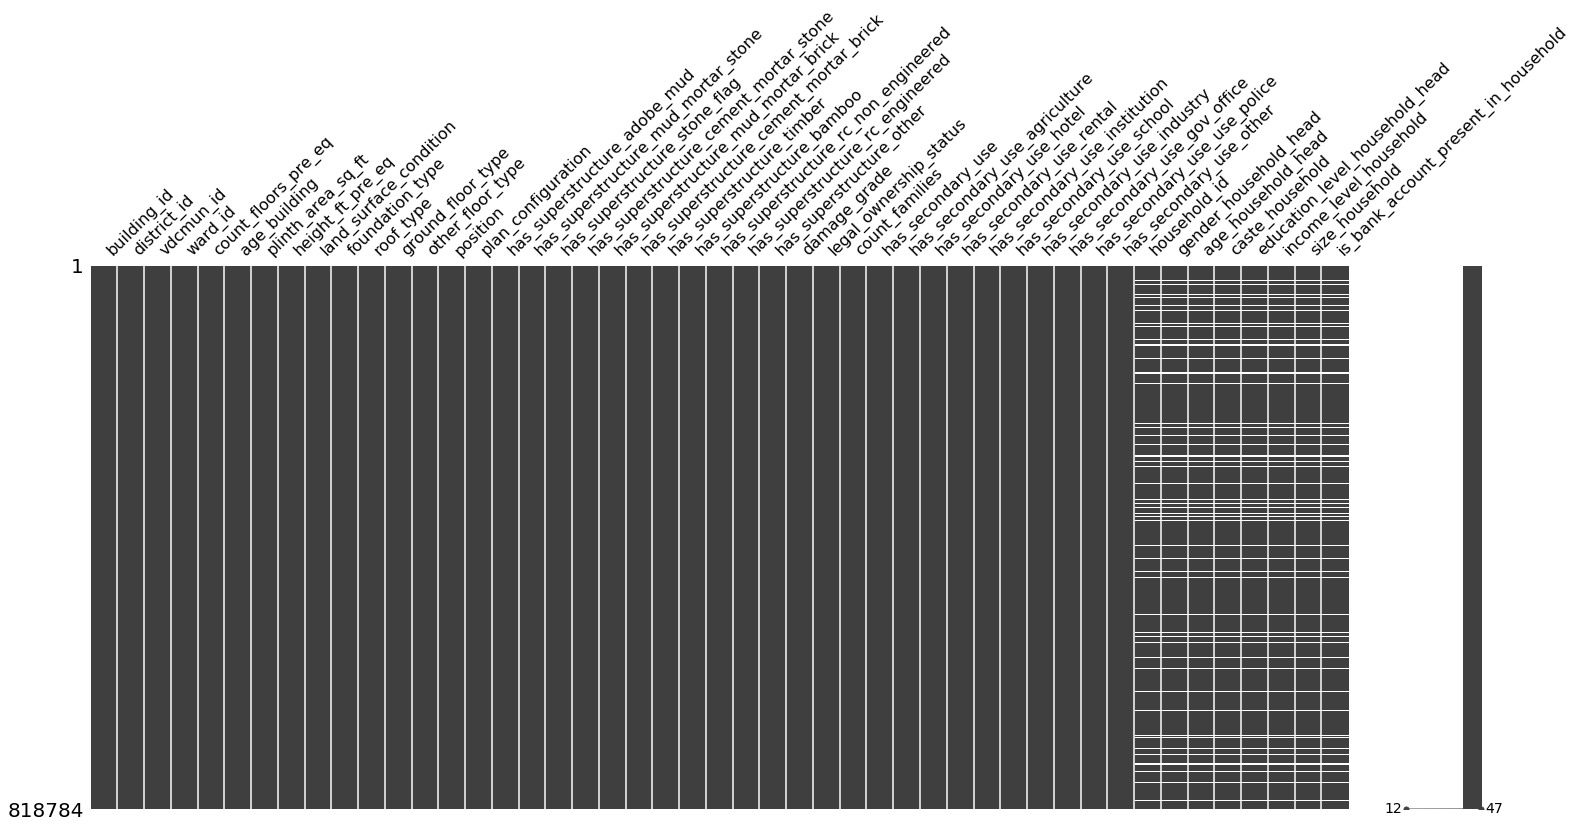

In [41]:
msno.matrix(building_household)
plt.show()

### ¿Qué son los 13 missing en las variables de building?

Vamos a entender por qué pone 13 edificios con missing: (hacemos la comprobación con damage grade por ejemplo)

In [42]:
damage_grade_nan = building_household[building_household["damage_grade"].isnull()]
damage_grade_nan

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,...,has_secondary_use_use_police,has_secondary_use_other,household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household
818771,212402000071,21,2107,210703,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.124020e+13,Male,43.0,Tamang,Non-formal education,Rs. 20-30 thousand,6.0,0.0
818772,212402000091,21,2107,210703,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.124020e+13,Male,74.0,Tamang,Illiterate,Rs. 10-20 thousand,4.0,0.0
818773,212402000201,21,2107,210703,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.124020e+13,Male,43.0,Tamang,Class 3,Rs. 10-20 thousand,6.0,0.0
818774,212402000211,21,2107,210703,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.124020e+13,Male,36.0,Tamang,Class 6,Rs. 10-20 thousand,5.0,0.0
818775,212402000221,21,2107,210703,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.124020e+13,Male,50.0,Tamang,Class 4,Rs. 10-20 thousand,3.0,0.0
818776,212402000221,21,2107,210703,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.124020e+13,Male,29.0,Tamang,SLC or equivalent,Rs. 50 thousand or more,3.0,0.0
818777,212402000341,21,2107,210703,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.124020e+13,Male,80.0,Tamang,Non-formal education,Rs. 10-20 thousand,13.0,0.0
818778,212402000361,21,2107,210703,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.124020e+13,Male,28.0,Newar,Class 5,Rs. 10-20 thousand,6.0,0.0
818779,212402000361,21,2107,210703,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.124020e+13,Male,40.0,Newar,Class 5,Rs. 10-20 thousand,6.0,0.0
818780,212402000371,21,2107,210703,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.124020e+13,Male,34.0,Newar,Class 5,Rs. 10-20 thousand,5.0,0.0


In [43]:
# Filtramos en el df1 (structure) original: (cogemos el primer edificio por ejemplo)
filter_df1= df1[df1["building_id"]== 212402000071]
filter_df1

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,...,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed
131627,212402000071,21,2107,210703,2,2,4,456,13,13,...,0,0,0,0,0,0,0,Damaged-Used in risk,NaN,NaN


In [44]:
# Filtramos en el df2 (ownership) original:
filter_df2= df2[df2["building_id"]== 212402000071]
filter_df2

,building_id,district_id,vdcmun_id,ward_id,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
131627,212402000071,21,2107,210703,Private,1.0,NaN,0,0,0,0,0,0,0,0,0,0


In [45]:
# Filtramos en el building (merge de structure + owership):
filter_building= building[building["building_id"]== 212402000071]
filter_building

# está vacio porque es unos de los missigs que hemos eliminado al hacer "building"

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,...,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other


In [46]:
# Filtramos en el household original
filter_household= household[household["building_id"]== 212402000071]
filter_household

,household_id,district_id,vdcmun_id,ward_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,building_id
123017,21240200007101,21,2107,210703,Male,43.0,Tamang,Non-formal education,Rs. 20-30 thousand,6.0,0.0,212402000071


Aqui aparece de nuevo porque hemos creado una columna llamada "building id" a partir de "household id" para poder cruzar, 
y este código vuelve a aparecer.
Las eliminamos porque no hay datos de esos households en el csv de building, además son solo 13

In [47]:
# Con quitar solo el registro en una variable se elimina en todas las demas, porque coinciden 
building_household= building_household.drop(building_household.loc[building_household['has_secondary_use_institution'].isnull()].index)

In [48]:
missing_values_table(building_household)

Your selected dataframe has 47 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
household_id,71647,8.8
gender_household_head,71647,8.8
age_household_head,71647,8.8
caste_household,71647,8.8
education_level_household_head,71647,8.8
income_level_household,71647,8.8
size_household,71647,8.8
is_bank_account_present_in_household,71647,8.8


In [49]:
building_household.shape

(818771, 47)

### ¿Por qué los 71.647 missing (NAN en demográficas)  no cuadran con los no hogares (71.576)?
### La diferencia es +71 ...

¿Qué son los 71.647? de aqui, 71.576 son los edificios no hogares, pero los 71 restantes??

In [50]:
familias_edificio_V2= building_household.groupby("count_families").count()
familias_edificio_V2

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,...,has_secondary_use_use_police,has_secondary_use_other,household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household
count_families,,,,,,,,,,,,,,,,,,,,,
0.0,71576,71576,71576,71576,71576,71576,71576,71576,71576,71576,...,71576,71576,0,0,0,0,0,0,0,0
1.0,643409,643409,643409,643409,643409,643409,643409,643409,643409,643409,...,643409,643409,643345,643345,643345,643345,643345,643345,643345,643345
2.0,79429,79429,79429,79429,79429,79429,79429,79429,79429,79429,...,79429,79429,79423,79423,79423,79423,79423,79423,79423,79423
3.0,17007,17007,17007,17007,17007,17007,17007,17007,17007,17007,...,17007,17007,17006,17006,17006,17006,17006,17006,17006,17006
4.0,4841,4841,4841,4841,4841,4841,4841,4841,4841,4841,...,4841,4841,4841,4841,4841,4841,4841,4841,4841,4841
5.0,1501,1501,1501,1501,1501,1501,1501,1501,1501,1501,...,1501,1501,1501,1501,1501,1501,1501,1501,1501,1501
6.0,617,617,617,617,617,617,617,617,617,617,...,617,617,617,617,617,617,617,617,617,617
7.0,188,188,188,188,188,188,188,188,188,188,...,188,188,188,188,188,188,188,188,188,188
8.0,120,120,120,120,120,120,120,120,120,120,...,120,120,120,120,120,120,120,120,120,120


Total registros = 818.771 (numero de familias + edificios no hogares)

- Familias que viven SOLAS en 1 edificio =  643.409  // 643.345 (diff: +64) 
- Familias que viven COMPARTEN en 1 edificio (2 plantas) =  79.429  //    79.423 (diff: +6)
- Familias que viven COMPARTEN en 1 edificio (3 plantas) =  17.007 //     17.006 (diff: +1)
                                      diff variables building vs variables demogr = +71

Edificios sin FAMILIA = 71.576  (sin datos houeholds )   VS 71.647 (missing) = 71.576 + 71 

¿qué son esos +71?
Se coge como ejemplo el de 3 familias, que la diferencia está solo en 1 building (17007 vs 17006) y es más fácil

In [51]:
diferencia= building_household[building_household["count_families"]== 3.0]
diferencia

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,...,has_secondary_use_use_police,has_secondary_use_other,household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household
1159,120206000211,12,1205,120502,2.0,4.0,480.0,18.0,Flat,Mud mortar-Stone/Brick,...,0.0,1.0,1.202060e+13,Male,31.0,Chhetree,SLC or equivalent,Rs. 10-20 thousand,3.0,1.0
1160,120206000211,12,1205,120502,2.0,4.0,480.0,18.0,Flat,Mud mortar-Stone/Brick,...,0.0,1.0,1.202060e+13,Male,28.0,Chhetree,Class 8,Rs. 10 thousand,5.0,0.0
1161,120206000211,12,1205,120502,2.0,4.0,480.0,18.0,Flat,Mud mortar-Stone/Brick,...,0.0,1.0,1.202060e+13,Male,21.0,Chhetree,SLC or equivalent,Rs. 10 thousand,2.0,1.0
2049,120306000241,12,1208,120802,2.0,25.0,392.0,24.0,Steep slope,Mud mortar-Stone/Brick,...,0.0,0.0,1.203060e+13,Male,59.0,Brahman-Hill,Class 5,Rs. 10 thousand,3.0,0.0
2050,120306000241,12,1208,120802,2.0,25.0,392.0,24.0,Steep slope,Mud mortar-Stone/Brick,...,0.0,0.0,1.203060e+13,Male,35.0,Brahman-Hill,SLC or equivalent,Rs. 10 thousand,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815155,366409000081,36,3611,361102,2.0,20.0,360.0,12.0,Moderate slope,Mud mortar-Stone/Brick,...,0.0,0.0,3.664090e+13,Male,38.0,Sunuwar,Class 2,Rs. 10 thousand,6.0,0.0
815156,366409000081,36,3611,361102,2.0,20.0,360.0,12.0,Moderate slope,Mud mortar-Stone/Brick,...,0.0,0.0,3.664090e+13,Male,30.0,Sunuwar,Class 2,Rs. 10 thousand,4.0,0.0
818258,366707000121,36,3603,360302,1.0,2.0,495.0,10.0,Flat,Cement-Stone/Brick,...,0.0,0.0,3.667070e+13,Female,26.0,Gurung,Class 5,Rs. 10-20 thousand,5.0,0.0
818259,366707000121,36,3603,360302,1.0,2.0,495.0,10.0,Flat,Cement-Stone/Brick,...,0.0,0.0,3.667070e+13,Male,20.0,Gurung,Class 10,Rs. 10-20 thousand,3.0,0.0


In [52]:
diferencia.shape

(17007, 47)

In [53]:
missing_values_table(diferencia)

Your selected dataframe has 47 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
household_id,1,0.0
gender_household_head,1,0.0
age_household_head,1,0.0
caste_household,1,0.0
education_level_household_head,1,0.0
income_level_household,1,0.0
size_household,1,0.0
is_bank_account_present_in_household,1,0.0


In [54]:
# Identificamos que building_id es el missing:

missing_household_id = diferencia[diferencia["household_id"].isnull()]
missing_household_id 

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,...,has_secondary_use_use_police,has_secondary_use_other,household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household
624663,304105001211,30,3013,301301,1.0,6.0,2000.0,10.0,Flat,RC,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# Este id está en building y dice que hay 3 familias

filter_prueba_building= building[building["building_id"]== 304105001211]
filter_prueba_building

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,...,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
579710,304105001211,30,3013,301301,1,6,2000,10,Flat,RC,...,1.0,0,0,1,0,0,0,0,0,1


In [56]:
# En household no está. Hay un error en la recogida de datos: hay id de building con familias pero no está en el csv de
# hogares. Son un total de 71. Los eliminamos

filter_prueba_household= household[household["building_id"]== 304105001211]
filter_prueba_household

,household_id,district_id,vdcmun_id,ward_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,building_id


In [57]:
# En building id_aparecen como NAN en demograpichs y con count families distinto de 0
# Si hacemos un filtro asi, los tendremos identificados

filter_prueba_building_household= building_household[building_household["building_id"]== 304105001211]
filter_prueba_building_household

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,...,has_secondary_use_use_police,has_secondary_use_other,household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household
624663,304105001211,30,3013,301301,1.0,6.0,2000.0,10.0,Flat,RC,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Identificamos esos 71 building_id con error en la recogida de datos:

In [58]:
copy= building_household.copy()

In [59]:
df = copy.drop(copy[(copy['count_families']!=0.0) & (copy['size_household'].isnull())].index)

In [60]:
df.shape

(818700, 47)

In [61]:
missing_values_table(df)

Your selected dataframe has 47 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
household_id,71576,8.7
gender_household_head,71576,8.7
age_household_head,71576,8.7
caste_household,71576,8.7
education_level_household_head,71576,8.7
income_level_household,71576,8.7
size_household,71576,8.7
is_bank_account_present_in_household,71576,8.7


Ahora en en df tenemos los "buildings no hogares" correctos. Los missing que nos salen son los no hogares, porque sus variables demograficas son NAN

In [62]:
df.head(20)

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,...,has_secondary_use_use_police,has_secondary_use_other,household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household
0,120101000011,12,1207,120703,1.0,9.0,288.0,9.0,Flat,Other,...,0.0,0.0,1.201010e+13,Male,31.0,Rai,Illiterate,Rs. 10 thousand,3.0,0.0
1,120101000021,12,1207,120703,1.0,15.0,364.0,9.0,Flat,Other,...,0.0,0.0,1.201010e+13,Female,62.0,Rai,Illiterate,Rs. 10 thousand,6.0,0.0
2,120101000031,12,1207,120703,1.0,20.0,384.0,9.0,Flat,Other,...,0.0,0.0,1.201010e+13,Male,51.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,13.0,0.0
3,120101000041,12,1207,120703,1.0,20.0,312.0,9.0,Flat,Other,...,0.0,0.0,1.201010e+13,Male,48.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,5.0,0.0
4,120101000051,12,1207,120703,1.0,30.0,308.0,9.0,Flat,Other,...,0.0,0.0,1.201010e+13,Male,70.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,8.0,0.0
5,120101000061,12,1207,120703,1.0,18.0,216.0,9.0,Flat,Other,...,0.0,0.0,1.201010e+13,Male,52.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,6.0,0.0
6,120101000071,12,1207,120703,1.0,13.0,234.0,9.0,Flat,Other,...,0.0,0.0,1.201010e+13,Male,27.0,Gharti/Bhujel,Class 5,Rs. 10-20 thousand,5.0,0.0
7,120101000081,12,1207,120703,1.0,8.0,280.0,9.0,Flat,Other,...,0.0,0.0,1.201010e+13,Male,31.0,Gharti/Bhujel,Class 4,Rs. 10 thousand,5.0,0.0
8,120101000091,12,1207,120703,1.0,22.0,268.0,9.0,Flat,Other,...,0.0,0.0,1.201010e+13,Male,44.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,9.0,0.0
9,120101000101,12,1207,120703,1.0,10.0,268.0,9.0,Flat,Other,...,0.0,0.0,1.201010e+13,Male,34.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,6.0,0.0


## Optimización del tipo de variables

In [63]:
df.dtypes

building_id                                 int64
district_id                                 int64
vdcmun_id                                   int64
ward_id                                     int64
count_floors_pre_eq                       float64
age_building                              float64
plinth_area_sq_ft                         float64
height_ft_pre_eq                          float64
land_surface_condition                     object
foundation_type                            object
roof_type                                  object
ground_floor_type                          object
other_floor_type                           object
position                                   object
plan_configuration                         object
has_superstructure_adobe_mud              float64
has_superstructure_mud_mortar_stone       float64
has_superstructure_stone_flag             float64
has_superstructure_cement_mortar_stone    float64
has_superstructure_mud_mortar_brick       float64


In [64]:
# Miramos el máximo de cada una de las variables para ver cuantos bits necesitaríamos para representarlas y 
# hasta donde podemos reducir el tipo:

df.max()

building_id                                366709001281
district_id                                          36
vdcmun_id                                          3611
ward_id                                          361108
count_floors_pre_eq                                   9
age_building                                        999
plinth_area_sq_ft                                  5000
height_ft_pre_eq                                     99
land_surface_condition                      Steep slope
foundation_type                                      RC
roof_type                                    RCC/RB/RBC
ground_floor_type                                Timber
other_floor_type                          Timber-Planck
position                                   Not attached
plan_configuration                              U-shape
has_superstructure_adobe_mud                          1
has_superstructure_mud_mortar_stone                   1
has_superstructure_stone_flag                   

In [65]:
# Cambiamos el tipo de las varibles 'índice' a objeto, ya que no tienen un orden  y por lo tanto no tiene sentido 
# que sean números:

inds = [df.columns[i] for i,x in enumerate(df.columns) if ('_id' in x)]
for i in inds:
    if df.dtypes[i]=='int64' or df.dtypes[i]=='float64':
        df[[i]]=df[[i]].astype(str)

In [66]:
# Cambiamos el tipo de las variables age_building y plinth_area_sq_ft de 64 a 16 bits, viendo el máximo 
# de estas variables vemos que necesitamos 16 bits para representarlas.

In [67]:
df['age_building']=np.int16(df['age_building'])
df['plinth_area_sq_ft']=np.int16(df['plinth_area_sq_ft'])

In [68]:
# Cambiamos el tipo del resto de las variables float64 que son dicotómicas o números pequeños que con 8 bits 
# es suficiente:

In [69]:
for i in df:
    if df.dtypes[i]=='float64':
        df[i]=np.int8(df[i])

In [70]:
df.dtypes

building_id                               object
district_id                               object
vdcmun_id                                 object
ward_id                                   object
count_floors_pre_eq                         int8
age_building                               int16
plinth_area_sq_ft                          int16
height_ft_pre_eq                            int8
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud                int8
has_superstructure_mud_mortar_stone         int8
has_superstructure_stone_flag               int8
has_superstructure_cement_mortar_stone      int8
has_superstructure_mud_mortar_brick         int8
has_superstructure_c

### Tratamiento NaN de los edificios "no hogares"

Vamos a rellenar esos missing asumiendo los NaN como una categoría más, pero hay variables numéricas:

NUMERICAS / BOOLEANAS:
- household_id (aunque es categórica es un número) -> hacerlo a parte y rellenarlo con "0"
- age_household_head
- size_household
- is_bank_account_present_in_household


CATEGÓRICAS:

- gender_household_head
- caste_household
- education_level_head
- income_level_household (Rs. 10 thousand,Rs. 10-20 thousand, Rs. 20-30 thousand)


In [71]:
# Tratamos los NaN de las categóricas como una categoria más, llamandola "no_familias"

df["gender_household_head"].replace(np.nan, 'no_familias', regex=True, inplace=True)
df["caste_household"].replace(np.nan, 'no_familias', regex=True, inplace=True)
df["education_level_household_head"].replace(np.nan, 'no_familias', regex=True, inplace=True)
df["income_level_household"].replace(np.nan, 'no_familias', regex=True, inplace=True)

Los NaN de las numéricas le ponemos un 0, pero luego no tenemos que considerarlo outliers.

In [72]:
df["household_id"].replace(np.nan, "0", regex=True, inplace=True)

In [73]:
df["is_bank_account_present_in_household"].replace(np.nan, 0, regex=True, inplace=True)
df["size_household"].replace(np.nan, 0, regex=True, inplace=True)
df["age_household_head"].replace(np.nan, 0, regex=True, inplace=True)

In [74]:
df.head(50)

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,...,has_secondary_use_use_police,has_secondary_use_other,household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household
0,120101000011,12,1207,120703,1,9,288,9,Flat,Other,...,0,0,12010100001101.0,Male,31,Rai,Illiterate,Rs. 10 thousand,3,0
1,120101000021,12,1207,120703,1,15,364,9,Flat,Other,...,0,0,12010100002101.0,Female,62,Rai,Illiterate,Rs. 10 thousand,6,0
2,120101000031,12,1207,120703,1,20,384,9,Flat,Other,...,0,0,12010100003101.0,Male,51,Gharti/Bhujel,Illiterate,Rs. 10 thousand,13,0
3,120101000041,12,1207,120703,1,20,312,9,Flat,Other,...,0,0,12010100004101.0,Male,48,Gharti/Bhujel,Illiterate,Rs. 10 thousand,5,0
4,120101000051,12,1207,120703,1,30,308,9,Flat,Other,...,0,0,12010100005101.0,Male,70,Gharti/Bhujel,Illiterate,Rs. 10 thousand,8,0
5,120101000061,12,1207,120703,1,18,216,9,Flat,Other,...,0,0,12010100006101.0,Male,52,Gharti/Bhujel,Illiterate,Rs. 10 thousand,6,0
6,120101000071,12,1207,120703,1,13,234,9,Flat,Other,...,0,0,12010100007101.0,Male,27,Gharti/Bhujel,Class 5,Rs. 10-20 thousand,5,0
7,120101000081,12,1207,120703,1,8,280,9,Flat,Other,...,0,0,12010100008101.0,Male,31,Gharti/Bhujel,Class 4,Rs. 10 thousand,5,0
8,120101000091,12,1207,120703,1,22,268,9,Flat,Other,...,0,0,12010100009101.0,Male,44,Gharti/Bhujel,Illiterate,Rs. 10 thousand,9,0
9,120101000101,12,1207,120703,1,10,268,9,Flat,Other,...,0,0,12010100010101.0,Male,34,Gharti/Bhujel,Illiterate,Rs. 10 thousand,6,0


In [75]:
df.dtypes

building_id                               object
district_id                               object
vdcmun_id                                 object
ward_id                                   object
count_floors_pre_eq                         int8
age_building                               int16
plinth_area_sq_ft                          int16
height_ft_pre_eq                            int8
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud                int8
has_superstructure_mud_mortar_stone         int8
has_superstructure_stone_flag               int8
has_superstructure_cement_mortar_stone      int8
has_superstructure_mud_mortar_brick         int8
has_superstructure_c

In [76]:
df.to_csv("./Data/paso_1.csv")